In [1]:
### Import required libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE
from collections import Counter

%matplotlib inline

In [35]:
### Read and explore train data
train_data_path = 'https://github.com/HamidSajjadi/sml-project-g40/raw/main/data/train.csv'
train_data = pd.read_csv(train_data_path)
print(train_data.shape)
print(train_data.columns)
train_data['Lead'].replace(['Male','Female'], [0,1], inplace=True)
train_data.head()

(1039, 14)
Index(['Number words female', 'Total words', 'Number of words lead',
       'Difference in words lead and co-lead', 'Number of male actors', 'Year',
       'Number of female actors', 'Number words male', 'Gross',
       'Mean Age Male', 'Mean Age Female', 'Age Lead', 'Age Co-Lead', 'Lead'],
      dtype='object')


,Number words female,Total words,Number of words lead,Difference in words lead and co-lead,Number of male actors,Year,Number of female actors,Number words male,Gross,Mean Age Male,Mean Age Female,Age Lead,Age Co-Lead,Lead
0,1512,6394,2251.0,343,2,1995,5,2631,142.0,51.500000,42.333333,46.0,65.0,1
1,1524,8780,2020.0,1219,9,2001,4,5236,37.0,39.125000,29.333333,58.0,34.0,0
2,155,4176,942.0,787,7,1968,1,3079,376.0,42.500000,37.000000,46.0,37.0,0
3,1073,9855,3440.0,2623,12,2002,2,5342,19.0,35.222222,21.500000,33.0,23.0,0
4,1317,7688,3835.0,3149,8,1988,4,2536,40.0,45.250000,45.000000,36.0,39.0,0


In [36]:
### Read final test data
fintest_data_path = 'https://github.com/HamidSajjadi/sml-project-g40/raw/main/data/test.csv'
fintest = pd.read_csv(fintest_data_path)
print(fintest.shape)
print(fintest.columns)
fintest.head()

(387, 13)
Index(['Number words female', 'Total words', 'Number of words lead',
       'Difference in words lead and co-lead', 'Number of male actors', 'Year',
       'Number of female actors', 'Number words male', 'Gross',
       'Mean Age Male', 'Mean Age Female', 'Age Lead', 'Age Co-Lead'],
      dtype='object')


,Number words female,Total words,Number of words lead,Difference in words lead and co-lead,Number of male actors,Year,Number of female actors,Number words male,Gross,Mean Age Male,Mean Age Female,Age Lead,Age Co-Lead
0,669,5388,2564.0,2241,8,2005,3,2155,46.0,33.571429,31.0,50.0,18.0
1,161,3468,1347.0,1186,5,2001,1,1960,278.0,39.600000,34.0,54.0,34.0
2,1720,14712,2818.0,2231,18,2008,5,10174,53.0,35.615385,40.0,23.0,28.0
3,3342,24930,11204.0,9912,13,2001,6,10384,81.0,40.416667,30.2,38.0,27.0
4,1520,14676,4378.0,2858,6,1992,1,8778,131.0,33.833333,34.0,46.0,34.0


In [4]:
train_data.columns

Index(['Number words female', 'Total words', 'Number of words lead',
       'Difference in words lead and co-lead', 'Number of male actors', 'Year',
       'Number of female actors', 'Number words male', 'Gross',
       'Mean Age Male', 'Mean Age Female', 'Age Lead', 'Age Co-Lead', 'Lead'],
      dtype='object')

In [5]:
train_data.dtypes

Number words female                       int64
Total words                               int64
Number of words lead                      int64
Difference in words lead and co-lead      int64
Number of male actors                     int64
Year                                      int64
Number of female actors                   int64
Number words male                         int64
Gross                                     int64
Mean Age Male                           float64
Mean Age Female                         float64
Age Lead                                  int64
Age Co-Lead                               int64
Lead                                      int64
dtype: object

In [6]:
### Target variable distribution - Imbalance classes
train_data['Lead'].value_counts()

0    785
1    254
Name: Lead, dtype: int64

In [7]:
### Number of records per year
train_data['Year'].value_counts().reset_index().sort_values('index')

,index,Year
46,1939,2
50,1949,1
41,1954,2
43,1958,2
40,1959,2
49,1960,1
45,1968,2
39,1972,3
37,1973,4
42,1974,2


### Data analysis task

The first step – before we start to build a model – is always to take a closer look at the data by analyzing some statistics of the data set. In this step you can already gain some insights into the data which helps you interpret the results of your methods later in the project.

Look into the provided data set by e.g. plotting the individual features. Based on your analysis, answer the following questions:

• Do men or women dominate speaking roles in Hollywood movies?

• Has gender balance in speaking roles changed over time (i.e. years)?

• Do films in which men do more speaking make a lot more money than films in which women speak more?

Write 1-2 sentences for each question and support your findings with evidence (statistics, plots, ...).

In [8]:
# Do men or women dominate speaking roles in Hollywood movies?
print(train_data['Number words female'].sum())
print(train_data['Number words male'].sum())

2425292
4739768


<ipython-input-9-72dd8e30e6f1>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  yearwise_genderdata = train_data.groupby(['Year'])['Number words male','Number words female'].sum()


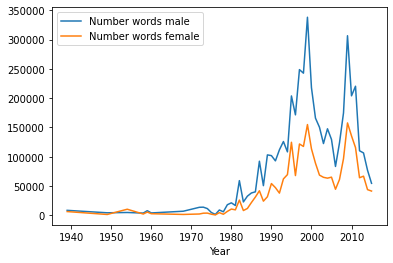

In [9]:
# Has gender balance in speaking roles changed over time (i.e. years)?
yearwise_genderdata = train_data.groupby(['Year'])['Number words male','Number words female'].sum()
yearwise_genderdata.plot()

In [10]:
yearwise_genderdata

,Number words male,Number words female
Year,,
1939,8573,6472
1949,4381,1512
1954,4902,10467
1958,3885,2263
1959,7975,5629
1960,4129,2809
1968,7067,1558
1972,13749,2321
1973,13994,3703


In [11]:
#Do films in which men do more speaking make a lot more money than films in which women speak more?
tempdata = train_data.copy()
tempdata['More Speaking'] = np.where(tempdata['Number words male']>tempdata['Number words female'],'Male','Female')
yearwise_grossdata = tempdata.groupby(['Year','More Speaking'])['Gross'].mean().unstack()
yearwise_grossdata

More Speaking,Female,Male
Year,,
1939,45.000000,839.000000
1949,NaN,8.000000
1954,30.000000,185.000000
1958,29.000000,38.000000
1959,880.000000,426.000000
1960,NaN,545.000000
1968,NaN,274.000000
1972,NaN,435.000000
1973,NaN,430.000000


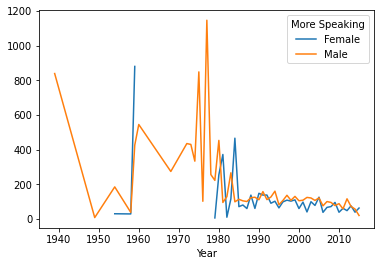

In [12]:
yearwise_grossdata.plot()

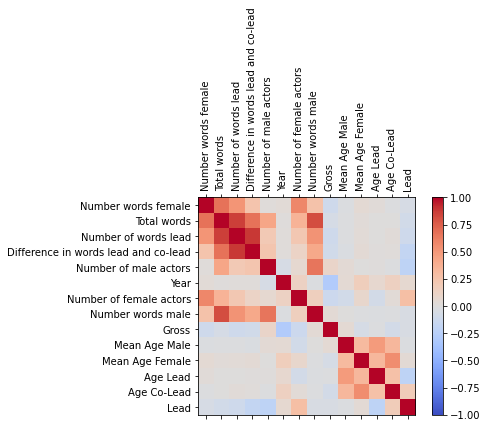

In [13]:
corr = train_data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(train_data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(train_data.columns)
ax.set_yticklabels(train_data.columns)
plt.show()

In [14]:
corr

,Number words female,Total words,Number of words lead,Difference in words lead and co-lead,Number of male actors,Year,Number of female actors,Number words male,Gross,Mean Age Male,Mean Age Female,Age Lead,Age Co-Lead,Lead
Number words female,1.000000,0.675952,0.522893,0.243032,0.022951,0.031966,0.579109,0.261024,-0.105242,-0.017222,0.048125,0.028985,-0.012089,-0.048869
Total words,0.675952,1.000000,0.865472,0.675772,0.429698,0.008032,0.359336,0.813092,-0.058728,-0.010137,0.025384,0.003216,0.001787,-0.082868
Number of words lead,0.522893,0.865472,1.000000,0.889529,0.205377,0.021614,0.219205,0.524019,-0.105794,-0.013091,0.035690,0.006557,0.024508,-0.104040
Difference in words lead and co-lead,0.243032,0.675772,0.889529,1.000000,0.235521,0.022759,0.117375,0.418632,-0.090914,-0.027046,0.039348,0.011029,0.021931,-0.178757
Number of male actors,0.022951,0.429698,0.205377,0.235521,1.000000,-0.052898,0.065826,0.663466,0.104351,0.045348,0.004131,0.013452,-0.011815,-0.203781
Year,0.031966,0.008032,0.021614,0.022759,-0.052898,1.000000,0.133975,-0.023008,-0.285317,0.049926,0.169557,0.074238,0.146904,0.068672
Number of female actors,0.579109,0.359336,0.219205,0.117375,0.065826,0.133975,1.000000,0.160032,-0.123554,-0.080817,0.089370,-0.077883,0.031431,0.281251
Number words male,0.261024,0.813092,0.524019,0.418632,0.663466,-0.023008,0.160032,1.000000,0.041563,0.002069,-0.010874,-0.017600,-0.010183,-0.043698
Gross,-0.105242,-0.058728,-0.105794,-0.090914,0.104351,-0.285317,-0.123554,0.041563,1.000000,0.048165,-0.056540,-0.013443,-0.073116,-0.046519
Mean Age Male,-0.017222,-0.010137,-0.013091,-0.027046,0.045348,0.049926,-0.080817,0.002069,0.048165,1.000000,0.319374,0.489811,0.334430,-0.021175


In [15]:
### Split the train and test data
np.random.seed(3)

trainIndex = np.random.choice(train_data.shape[0], size=int(len(train_data)*.8), replace=False)

### Scale some variables to make it normally distributed - more details in report
logscaled = ['Number words female', 'Number of words lead',
       'Difference in words lead and co-lead', 
       'Number of male actors', 
       'Number of female actors', 'Number words male']
for i in logscaled:
    train_data[i] = np.log(train_data[i] + 1)

train = train_data.iloc[trainIndex]                     #training set
test = train_data.iloc[~train_data.index.isin(trainIndex)]   #test set

X_train = train.drop(columns=['Lead'])
y_train = train['Lead']
X_test = test.drop(columns=['Lead'])
y_test = test['Lead']

In [16]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(831, 13) (831,)
(208, 13) (208,)


In [17]:
# Randomly over sample the minority class
smote = SMOTE(random_state=3)
X_train_smote, y_train_smote= smote.fit_resample(X_train, y_train)

# Check the number of records after over sampling
print(sorted(Counter(y_train_smote).items()))

[(0, 628), (1, 628)]


Accuracy is 0.899
Precision is 0.768
Recall is is 0.843
F1-Score is 0.804
Confusion Matrix: 
 [[144  13]
 [  8  43]]


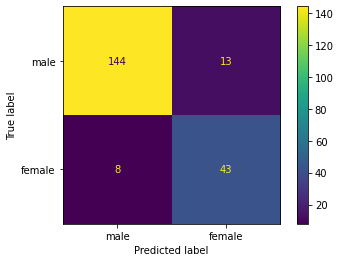

In [18]:
### Base gradient boosting model
np.random.seed(3)

model = GradientBoostingClassifier()

model.fit(X=X_train_smote, y=y_train_smote)
y_predict = model.predict(X_test)

print('Accuracy is %.3f' % accuracy_score(y_test, y_predict))
print('Precision is %.3f' % precision_score(y_test, y_predict))
print('Recall is is %.3f' % recall_score(y_test, y_predict))
print('F1-Score is %.3f' % f1_score(y_test, y_predict))

cm = confusion_matrix(y_test, y_predict)
print('Confusion Matrix: \n', cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["male", "female"])
disp.plot()
plt.show()

In [19]:
### Feature importance based on base gradient boosting model
imp_features = dict(zip(X_train.columns, model.feature_importances_))
sorted_keys = sorted(imp_features, key=imp_features.get, reverse=True)

sorted_dict = dict()

for f in sorted_keys:
    sorted_dict[f] = imp_features[f]

sorted_dict

{'Number of female actors': 0.2632204876662886,
 'Number words female': 0.22827895925421957,
 'Number of male actors': 0.14311234810421616,
 'Age Lead': 0.09104107223564367,
 'Difference in words lead and co-lead': 0.08965085366886269,
 'Age Co-Lead': 0.06814509363828757,
 'Number words male': 0.033121476368704945,
 'Mean Age Female': 0.026012663311595137,
 'Number of words lead': 0.016913680819752846,
 'Mean Age Male': 0.015912182063125807,
 'Total words': 0.01554185778291548,
 'Gross': 0.005426853731387449,
 'Year': 0.003622471355000365}

In [20]:
X_train_smote.columns

Index(['Number words female', 'Total words', 'Number of words lead',
       'Difference in words lead and co-lead', 'Number of male actors', 'Year',
       'Number of female actors', 'Number words male', 'Gross',
       'Mean Age Male', 'Mean Age Female', 'Age Lead', 'Age Co-Lead'],
      dtype='object')

In [21]:
### Remove some features based on high correlation and/or low feature importance
X_train_smote_fin = X_train_smote.drop(columns=['Total words', 'Gross', 'Year'])
X_test_fin = X_test.drop(columns=['Total words', 'Gross', 'Year'])

fintest = fintest.drop(columns=['Total words', 'Gross', 'Year'])

In [22]:
X_train_smote_fin.columns

Index(['Number words female', 'Number of words lead',
       'Difference in words lead and co-lead', 'Number of male actors',
       'Number of female actors', 'Number words male', 'Mean Age Male',
       'Mean Age Female', 'Age Lead', 'Age Co-Lead'],
      dtype='object')

In [23]:
X_test_fin.columns

Index(['Number words female', 'Number of words lead',
       'Difference in words lead and co-lead', 'Number of male actors',
       'Number of female actors', 'Number words male', 'Mean Age Male',
       'Mean Age Female', 'Age Lead', 'Age Co-Lead'],
      dtype='object')

CPU times: user 93 µs, sys: 16 µs, total: 109 µs
Wall time: 112 µs
Fitting 5 folds for each of 75 candidates, totalling 375 fits
{'model__learning_rate': 1, 'model__max_depth': 3, 'model__n_estimators': 500}
0.9148390564725226
Accuracy is 0.928
Precision is 0.833
Recall is is 0.882
F1-Score is 0.857
Confusion Matrix: 
 [[148   9]
 [  6  45]]


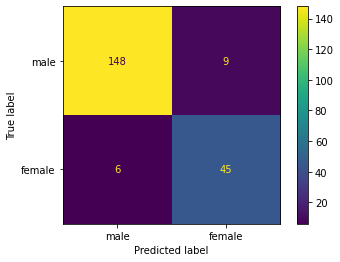

In [24]:
### Finding best model and best parameters for the model using Grid Search CV
parameters = {
"model__n_estimators":[5,50,250,500,1000],
"model__max_depth":[1,3,5,7,9],
"model__learning_rate":[0.01,0.1,1],
}

%time model = Pipeline([('scaler', RobustScaler()), ('model', GradientBoostingClassifier(random_state=3))])

gb_clf1 = GridSearchCV(estimator = model,
                        param_grid = parameters, 
                        refit="accuracy",
                        scoring=["f1", "accuracy", "precision","recall"],
                        cv = 5,
                        n_jobs = -1,
                        verbose = True
                        )

gb_clf1.fit(X_train_smote_fin, y_train_smote)

print(gb_clf1.best_params_)
print(gb_clf1.best_score_)

y_pred_gb1 = gb_clf1.predict(X_test_fin)

print('Accuracy is %.3f' % accuracy_score(y_test, y_pred_gb1))
print('Precision is %.3f' % precision_score(y_test, y_pred_gb1))
print('Recall is is %.3f' % recall_score(y_test, y_pred_gb1))
print('F1-Score is %.3f' % f1_score(y_test, y_pred_gb1))

cm_gb1 = confusion_matrix(y_test, y_pred_gb1)
print('Confusion Matrix: \n', cm_gb1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_gb1, display_labels=["male", "female"])
disp.plot()
plt.show()

**Final Result:**

Accuracy is 0.928

Precision is 0.833

Recall is is 0.882

F1-Score is 0.857

Confusion Matrix: 
 [[148   9]
 [  6  45]]

### Mount google drive

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Save final model

In [30]:
from joblib import dump, load
dump(gb_clf1, '/content/drive/MyDrive/UU/SML_Project/Model/gbclf_fin.joblib') 

gbclf_fin = load('/content/drive/MyDrive/UU/SML_Project/Model/gbclf_fin.joblib') 

### Model Prediction on Final Test Data for Submission

In [31]:
fintest_pred_gbclf_fin = gbclf_fin.predict(fintest)

In [32]:
fintest_pred_gbclf_fin_df = pd.DataFrame(fintest_pred_gbclf_fin)
fintest_pred_gbclf_fin_df.value_counts()

0    366
1     21
dtype: int64

In [33]:
fintest_pred_gbclf_fin

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [34]:
fintest_pred_gbclf_fin.tofile('/content/drive/MyDrive/UU/SML_Project/Output/predictions.csv', sep = ',')